In [1]:
import os
import re
from collections import defaultdict
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import omdb
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from googleapiclient.discovery import build
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud



pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(path, binary=True)
# It is much faster take less than 2 minutes


OMDB_API_KEY = os.environ.get('OMDB_API_KEY')
omdb.set_default('apikey', OMDB_API_KEY)

YOUTUBE_API_KEY = os.environ.get('YOUTUBE_API_KEY')
youtube = build('youtube','v3',developerKey=YOUTUBE_API_KEY)

# 2. Functions

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    text = [w for w in text.split(' ') if w not in ['im','dont','cant','wont','shouldnt','couldnt','wouldnt']]
    return_text = ' '.join(text)
    return return_text

In [3]:
def tokenise(doc):
    return [token.text for token in nlp(doc)]

In [4]:
def tokenise_lemma(doc):
    """
    Use spacy as the nlp object to tokenise each doc
    Lemmatise each words
    """
    return ' '.join([token.lemma_ for token in nlp(doc)])

In [5]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    """
    Use tokenised words to get vectors representations from the pretrained model (i.e. second_map).
    Average the vector representation of the description as the representation of the document 
    (i.e. each movie title's representation is the mean of vectors of each words in its description)
    """
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [6]:
def search(name, df):
    return df.loc[df['title'].str.lower()==name.lower()]

In [7]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values.tolist()[0]
        gen = search(uid, df).genres.values.tolist()[0]
        year = search(uid, df).year.values.tolist()[0]
        sim.append((uid, thisSim[0][0], org, gen, year))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+1]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres', 'year'],
                           data = sim)
    return returnDf

In [8]:
def get_most_similar(lookup_id, title_vec, df):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [9]:
def filter_df(keyword):
    """
    Return a dataframe with the filtered result.
    The input value is case-insensitive. 
    """
    if type(keyword) == list:
        return netflixDf.loc[netflixDf['title'].isin(keyword)]
    else:
        return netflixDf.loc[netflixDf['title'].str.lower().isin([keyword.lower()])]

In [10]:
def markerX(key, values):
    return netflixDf.loc[netflixDf[key].str.lower().isin(values)].sort_values(by='pca_2', ascending=False)

def others(key, values):
    return netflixDf.loc[~netflixDf[key].str.lower().isin(values)]

In [11]:
def vec_representation(DF):
    '''
    This function takes a dataframe to produce a title-vector mapping dictionary.
    For the use of the later recommender systems. 
    '''
    TkDocs = [tokenise(doc) for doc in DF.everything.values.tolist()] #tokenise 
    # mapping out the title and each description. so later on i can search 
    Map = dict(zip(DF['title'].str.lower().tolist(), TkDocs))
    # lower the title (easy for search)
    titleVec = get_vectors(Map, w2v)
    return titleVec

In [92]:
def omdb_get(title,year, media_type):
    movie_info = omdb.get(title=title, year = year, fullplot = True, media_type=media_type)
    temp = pd.DataFrame(data=[movie_info])
    return temp

# Pipeline Functions

In [13]:
def show_values_on_bars(axs, h_v="v", space=0.4, round_out=True):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if round_out == True:
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center") 
                else:
                    value = p.get_height()
                    ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                if round_out == True:
                    value = int(p.get_width())
                    ax.text(_x, _y, value, ha="left") 
                else:
                    value = p.get_width()
                    ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [174]:
def year_analysis(df, save=False, title=None):
    title = df.title.tolist()[0]
    year = pd.DataFrame()
    year['year'] = df.year.value_counts().index.tolist()
    year['count'] = df.year.value_counts().tolist()
    year = year.astype(int).sort_values(by='year')
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x='year', y='count', data=year, ax=ax)
    show_values_on_bars(ax)
    ax.set_title(f"Year Analysis of {title}'s top 10 similar titles")
    plt.show()
    
    if save==True:
        fileName = input()
        plt.savefig(fileName+'.png')

In [175]:
def genre_analysis(df, save=False, title=None):
    title = df.title.tolist()[0]
    count = defaultdict(int)
    for g in df.genre:
        for each in g.split(','):
            each = each.rstrip().lstrip()
            count[each] += 1
    genre_analysis = pd.DataFrame(data=[count])
    genre_analysis = genre_analysis.transpose().reset_index().rename(columns={'index':'genre',0:'count'})
    genre_analysis = genre_analysis.sort_values(by='count', ascending=False)

    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x='genre', y='count', data=genre_analysis)
    show_values_on_bars(ax)
    plt.title(f"Genre Analysis of {title}'s top 10 similar titles'")
    plt.show()
    
    if save==True:
        fileName = input()
        plt.savefig(fileName+'.png')

In [16]:
def imdb_analysis(df):
    
    idx = ['median', 'mean', 'max', 'min']
    cols = ['imdb_rating','imdb_votes']
    analysisDf = pd.DataFrame(index=idx, columns=cols)
    imdb = df.imdb_rating.tolist()
    imdb = [float(i) for i in imdb]
    rating_list = [np.median(imdb), np.mean(imdb), np.max(imdb), np.min(imdb)]
    rating_list = [round(k,2) for k in rating_list]
    
    votes = df.imdb_votes.tolist()
    votes = [int(j) for j in [count.replace(',','') for count in votes]]
    votes_list = [np.median(votes), np.mean(votes), np.max(votes), np.min(votes)]
    votes_list = [round(h) for h in votes_list]
    
    analysisDf['imdb_rating'] = rating_list
    analysisDf['imdb_votes'] = votes_list
    
    return analysisDf

In [164]:
# any originals in its 10 recommendations?
def check_originals(df, org):
    l = []
    for t in df.title:
        if t.lower() in org:
            l.append(t)
    return l

In [176]:
def pipeline(df, media_type='movie'):
    '''
    This function shows the year analysis, genre analyis, imdb analysis, and finally it checks if there is any Netflix Originals included.
    '''
    if media_type=='movie':
        year_analysis(df)
        genre_analysis(df)
        print(imdb_analysis(df))
        print(check_originals(df, orgMovie))
    else:
        year_analysis(df)
        genre_analysis(df)
        print(imdb_analysis(df))
        print(check_originals(df, orgTvshow))

# Youtube PIPELINE FUNCTIONS

In [19]:
def video_stats(list_of_titles):
    statsDf = pd.DataFrame(columns=['viewCount','likeCount','dislikeCount','favoriteCount','commentCount'])
    for title in list_of_titles:

        rq = youtube.videos().list(
                part="statistics",
                id=videoIds[title])
        rs = rq.execute()
        stats = rs['items'][0]['statistics']
        temp = pd.DataFrame(data=[stats], columns=['viewCount','likeCount','dislikeCount','favoriteCount','commentCount'], index=[title]).astype(int)
        statsDf = statsDf.append(temp)
    statsDf = statsDf.sort_values(by='viewCount', ascending=False)
    return statsDf

In [20]:
# test to retrieve 1000 comments
def get_1kcomments(videoId, preprocess=True):
    '''
    The function returns a list of 1000 comments.
    
    '''
    rq = youtube.commentThreads().list(
            part="snippet,replies",
            maxResults = 100,
            videoId=videoId)

    comments_list = list()
    nextPageToken = list()

    for i in range(10):
        if i == 0:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId)
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
        else:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId,
                pageToken=nextPageToken[i-1])
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
    if preprocess == True:
        return [preprocess_text(comment) for comment in comments_list]
    else:
        return comments_list

In [21]:
def sentiment(preprocessed_comments):
    '''
    This function returns a dataframe consisting of polarity and subjectivity of the given movie reviews.
    '''
    polarity = list()
    subjectivity = list()
    for comment in preprocessed_comments:
        tb = TextBlob(comment)
        polarity.append(tb.sentiment[0])
        subjectivity.append(tb.sentiment[1])
    
    df = pd.DataFrame()
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity
    return df

In [22]:
def create_wordcloud(preprocessed_comments, file_name='noID', max_font_size=150, max_words=100, background_color="white"):
    all_comments = ','.join(preprocessed_comments).replace(',', ' ').replace('movie', ' ')
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(all_comments)
    wordcloud.to_file(file_name+'.png')
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [23]:
def sentiment_counts(df):
    '''
    This function returns a dataframe containing the value counts of sentiment
    '''
    sent = defaultdict(int)
    for v in df['polarity']:
        if v > 0.1:
            sent['positive'] += 1
        elif v < -0.1:
            sent['negative'] += 1
        else:
            sent['neutral'] += 1
    tempdf = pd.DataFrame(data = [sent], columns=['positive','neutral','negative'])
    tempdf = tempdf.transpose().reset_index().rename(columns={'index':'sentiment',0:'count'})
    tempdf['percentage'] = tempdf['count'].apply(lambda x: x/tempdf['count'].sum())
    
    return tempdf

In [24]:
def show_sentiment_counts(df):
    fig, ax = plt.subplots(1,2, figsize=(16,6))

    raw_count = sns.barplot(x='sentiment', y='count', data=df, ax=ax[0])
    percentage = sns.barplot(x='sentiment', y='percentage', data=df, ax=ax[1])
    show_values_on_bars(ax[0])
    show_values_on_bars(ax[1], round_out=False)
    ax[0].set_title('Raw Counts')
    ax[1].set_title('Percentage')
    plt.show()

In [25]:
def plot_sentiments(df):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='polarity', y='subjectivity', data=df)
    plt.show()

In [26]:
def youtube_pipeline(list_of_titles):
    print(video_stats(list_of_titles))
    
    for title in list_of_titles:
        
        comments = get_1kcomments(videoIds[title])
        create_wordcloud(comments)
        sent = sentiment(comments)
        plot_sentiments(sent)
        sent_count = sentiment_counts(sent)
        show_sentiment_counts(sent_count)
    

# 整體分析 function

In [32]:
def count_genres(genre_list):
    """
    genre_list is pd sereis
    return a dataframe
    """
    genres_count = defaultdict(int)
    for movie in genre_list:
        for genre in movie.split(','):
            genres_count[genre] += 1
    df = pd.DataFrame(data=[genres_count])
    df = df.transpose().reset_index().rename(columns={'index':'genres',0:'counts'}).sort_values(by = 'counts', ascending=False).reset_index(drop=True)
    df['percentage'] = df['counts'].apply(lambda x: round(x/df.counts.sum(),2))
    return df

In [33]:
def trend_in_yearN(df ,genre , N):
    """
    return how many title's are in the given genre in the given year.
    """
    x = count_genres(df.loc[df['year']== N].genres.values.tolist())
    return x.set_index('genres').loc[genre].values.tolist()[0]

In [34]:
def ten_year_trend(df, genre, s=2010, e=2020):
    """
    default setting start with 2010 end with 2019 (10 years).
    return a dictionary
    """
    trend = defaultdict(int)
    for key in range(s, e):
        year = str(key)
        trend[key] = trend_in_yearN(df, genre, year)
    return trend

In [35]:
def create_trend_dataframe(df, cols):
    """
    df = from which df to produce ten_year_trend
    cols = list of genres you want to include
    """
    trend_df = pd.DataFrame()
    for genre in cols:
        temp = pd.DataFrame(data=[ten_year_trend(df, genre)]).transpose().rename(columns={0:genre})
        trend_df = pd.concat([trend_df, temp], axis=1)
    return trend_df

# 總體電影 (3770) 部 分析

In [12]:
movieDf = pd.read_csv('movie_dataset_july18.csv', usecols=['title','genres','year','type','originals','everything'])

In [424]:
mv_org = movieDf.loc[movieDf['originals']==1].copy()

mv_genres_count = count_genres(movieDf.genres.values.tolist())
mv_org_genres_count = count_genres(mv_org.genres.values.tolist())

mv_genres_count['percentage'] = mv_genres_count['counts'].apply(lambda x: round(x/mv_genres_count.counts.sum(),2))
mv_org_genres_count['percentage'] = mv_org_genres_count['counts'].apply(lambda x: round(x/mv_org_genres_count.counts.sum(),2))

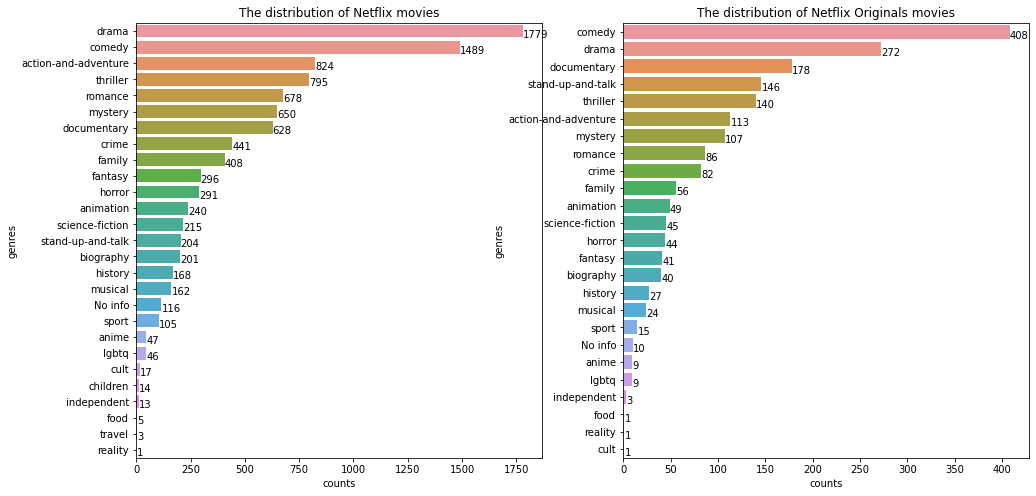

In [425]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.show()

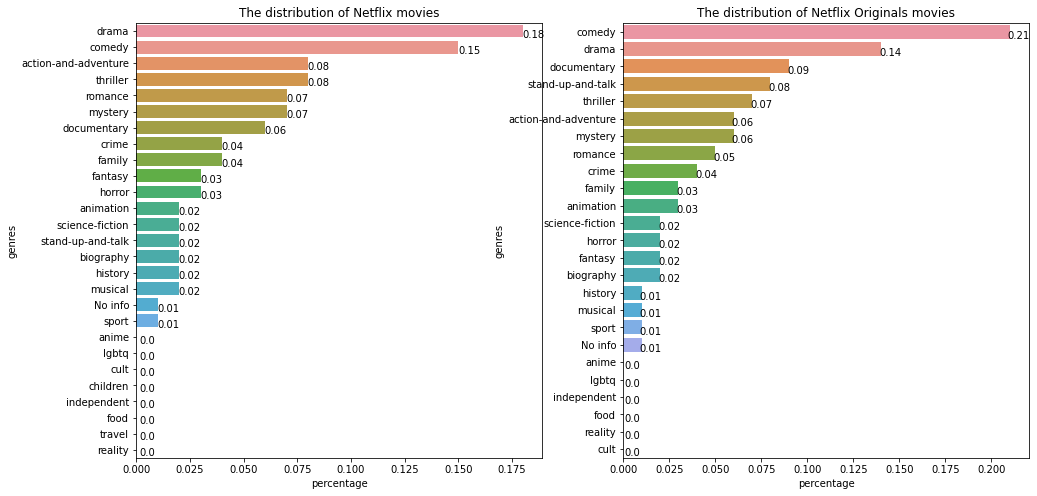

In [426]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
show_values_on_bars(bar, h_v='h',space=0.005, round_out=False)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
show_values_on_bars(bar, h_v='h',space=0.005, round_out=False)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.savefig('movie%.png')
plt.show()

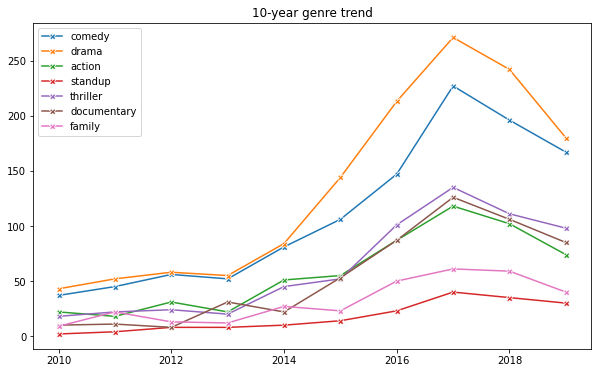

In [403]:
comedy = ten_year_trend(movieDf, 'comedy')
drama = ten_year_trend(movieDf, 'drama')
action = ten_year_trend(movieDf, 'action-and-adventure')
standup = ten_year_trend(movieDf, 'stand-up-and-talk')
thriller = ten_year_trend(movieDf, 'thriller')
documentary = ten_year_trend(movieDf, 'documentary')
family = ten_year_trend(movieDf, 'family')

fig, ax = plt.subplots(figsize=(10,6))
cd = sns.lineplot(x = list(comedy.keys()), y = list(comedy.values()), marker = 'X', ax = ax, label='comedy')
dm = sns.lineplot(x = list(drama.keys()), y = list(drama.values()), marker = 'X', ax = ax, label='drama')
ac = sns.lineplot(x = list(action.keys()), y = list(action.values()), marker = 'X', ax = ax, label='action')
st = sns.lineplot(x = list(standup.keys()), y = list(standup.values()), marker = 'X', ax = ax, label='standup')
tl = sns.lineplot(x = list(thriller.keys()), y = list(thriller.values()), marker = 'X', ax = ax, label='thriller')
dc = sns.lineplot(x = list(documentary.keys()), y = list(documentary.values()), marker = 'X', ax = ax, label='documentary')
fm = sns.lineplot(x = list(family.keys()), y = list(family.values()), marker = 'X', ax = ax, label='family')

ax.set_title('10-year genre trend')
plt.show()

In [406]:
cols = ['drama','comedy','action-and-adventure','thriller','romance',
        'mystery', 'documentary','crime','family','fantasy']
create_trend_dataframe(movieDf, cols)

## Create Corpus and apply word embedding

In [13]:
# movieTkDocs = [tokenise(doc) for doc in movieDf.everything.values.tolist()] #tokenise 
# # mapping out the title and each description. so later on i can search 
# movieMap = dict(zip(movieDf['title'].str.lower().tolist(), movieTkDocs))
# # lower the title (easy for search)
movieTitleVec = vec_representation(movieDf)

## top 10 movies analysis

In [17]:
top_10_movie = [
    'Bird Box',
    'Murder Mystery',
    'Triple Frontier',
    'The Perfect Date',
    'Tall Girl',
    'The Highwaymen',
    'Secret Obsession',
    'Always Be My Maybe',
    'Otherhood',
    'FYRE: The Greatest Party That Never Happened'
]

In [434]:
top10_and_10sim = pd.DataFrame()
for movie in top_10_movie:
    df = get_topN_similar(movie, movieTitleVec, movieDf)
    top10_and_10sim = top10_and_10sim.append(df, ignore_index=True)

In [19]:
# Only the silence_2019 has name issue. Handled it seperately.
t = top10_and_10sim.title.tolist()
t[1] = 'the silence'
top10_and_10sim['title'] = t

In [20]:
# top10_and_10sim.to_csv('similar.csv')

In [28]:
titles_for_omdb = top10_and_10sim.title.tolist()
year_for_omdb = top10_and_10sim.year.tolist()

### Manually change incorrect information

In [29]:
year_for_omdb[29] = 2016
titles_for_omdb[39] = '#TemanTapiMenikah'
titles_for_omdb[67] = 'silent hill: revelation'
year_for_omdb[85] = 2014
titles_for_omdb[98] = 'the meyerowitz stories'
titles_for_omdb[99] = 'fyre'
titles_for_omdb[100] = 'theater of life'
titles_for_omdb[102] = 'woodstock'
titles_for_omdb[104] = 'Cézanne et moi'
year_for_omdb[106] = 2017
titles_for_omdb[108] = 'Todo sobre el asado'

In [31]:
omdb_results = pd.DataFrame()
for ix in range(110):
    try:
        omdb_results = omdb_results.append(omdb_get(titles_for_omdb[ix],year_for_omdb[ix]), ignore_index=True)
    except:
        print(ix)

## OMDB_RESULT年份分析

In [32]:
year_analysis = sorted(dict(omdb_results['year'].value_counts()).items(), key=lambda x: int(x[0]))

In [33]:
year_graph = pd.DataFrame(data=year_analysis)
# year_graph.rename(columns={0:'year',1:'count'}, inplace=True)

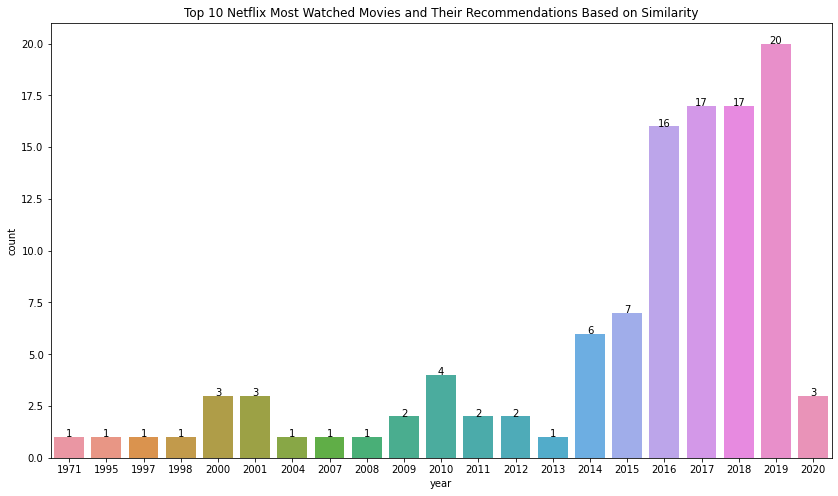

In [36]:
# year_graph.rename(columns={0:'year',1:'count'}, inplace=True)
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x='year', y='count', data=year_graph)
show_values_on_bars(ax)
plt.title('Top 10 Netflix Most Watched Movies and Their Recommendations Based on Similarity')
plt.show()

In [37]:
# How many originals?
sim = top10_and_10sim.title.tolist()
sim = [i for i in sim if i not in [l.lower() for l in top_10_movie]]

In [38]:
orgMovie = []
for mv in sim:
    if search(mv, movieDf).originals.values == 1:
        orgMovie.append(mv)

In [39]:
(orgMovie)

['the silence',
 'the forest of love',
 'how it ends',
 'mute',
 'the crew',
 'extraction',
 'coin heist',
 'the half of it',
 'love is blind',
 'extremely wicked, shockingly evil and vile',
 'dangerous lies',
 'how to get over a breakup',
 'back to school',
 'the meyerowitz stories (new and selected)']

總共有14部電影是originals

In [274]:
mapping_for_mvCopies = defaultdict(str)
for i in range(10):
    if i != 9:
        mapping_for_mvCopies[f"mv0{str(i+1)}"] = top_10_movie[i]
    else:
        mapping_for_mvCopies["mv10"] = top_10_movie[i]

In [277]:
mv01 = omdb_results.iloc[0:11,:].copy()
mv02 = omdb_results.iloc[11:22,:].copy()
mv03 = omdb_results.iloc[22:33,:].copy()
mv04 = omdb_results.iloc[33:44,:].copy()
mv05 = omdb_results.iloc[44:55,:].copy()
mv06 = omdb_results.iloc[55:66,:].copy()
mv07 = omdb_results.iloc[66:77,:].copy()
mv08 = omdb_results.iloc[77:88,:].copy()
mv09 = omdb_results.iloc[88:99,:].copy()
mv10 = omdb_results.iloc[99:110,:].copy()

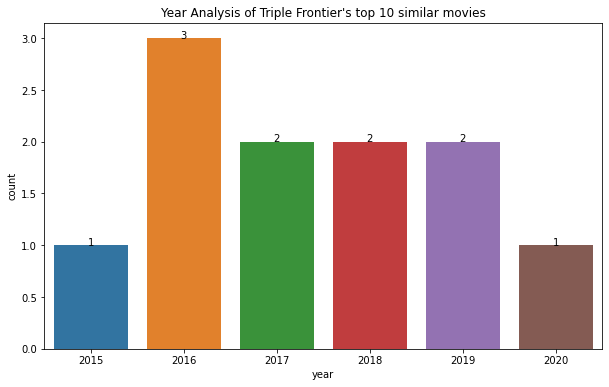

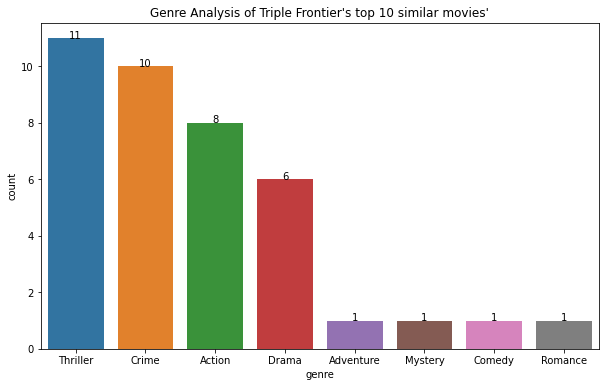

        imdb_rating  imdb_votes
median         6.30       28731
mean           5.98       42500
max            7.00      129468
min            4.80         516
['The Crew', 'Extraction', 'Coin Heist']


In [365]:
pipeline(mv03)

## YouTube Analysis
There are 4 movies are originals.
Go to Netflix channel to grab videoID

In [314]:
# a mapping for video ID
videoIds = {
    'bird box':'o2AsIXSh2xo',
    'the silence': 'Y-ufZuqTd5c',
    'the forest of love':'ybsrYkz0V0A',
    'how it ends':'WJyyJ7lexnM',
    'mute':'ma8te7ywEio',
    'triple frontier':'Fo3yRLLrXQA',
    'extraction':'L6P3nI6VnlY',
    'coin heist':'xUyTRSlmXf4'
}

In [209]:
request = youtube.commentThreads().list(
        part="snippet,replies",
        maxResults = 100,
        videoId=videoIds['the silence'])

In [210]:
response = request.execute()

## YOUTBUE ANALYSIS PIPELINE

                viewCount likeCount dislikeCount favoriteCount commentCount
extraction       12032600    217356         7387             0        16640
triple frontier   6706501     46939         1276             0         3933
coin heist        5893780     52297         1951             0         1564


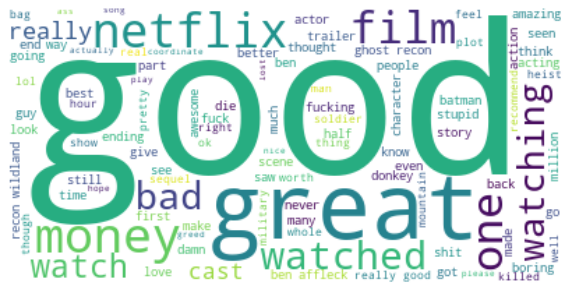

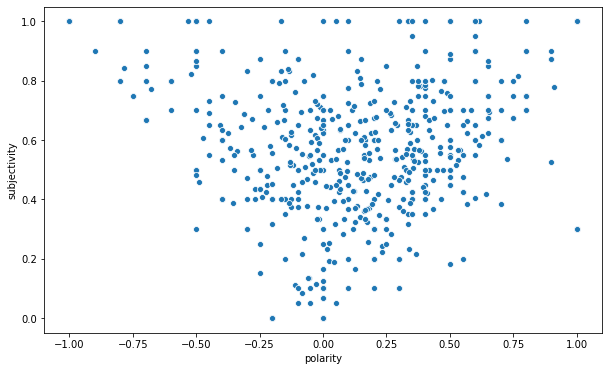

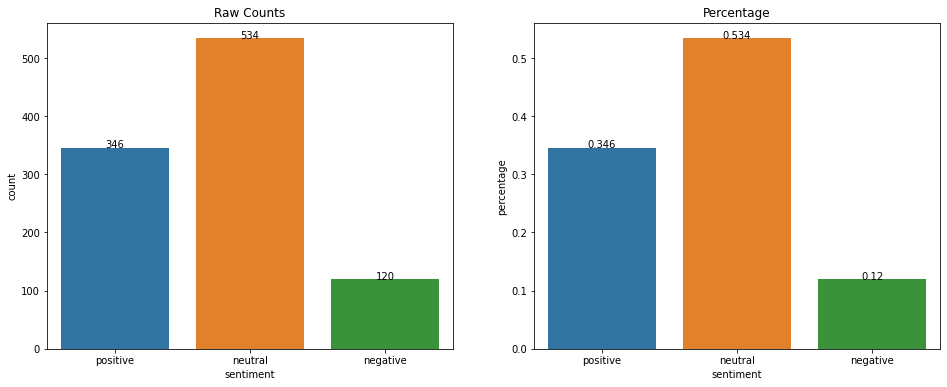

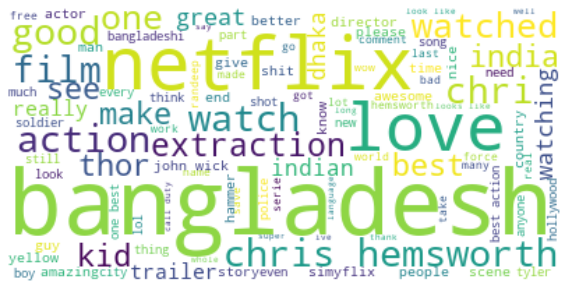

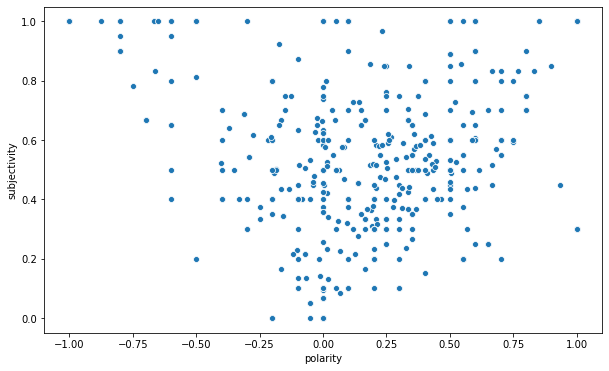

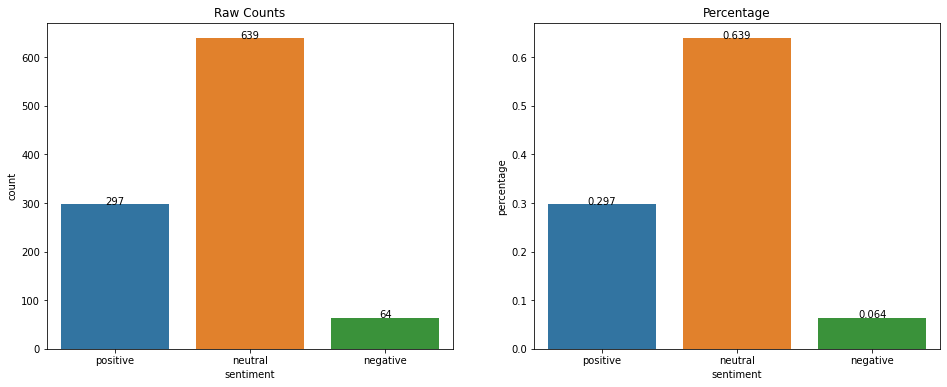

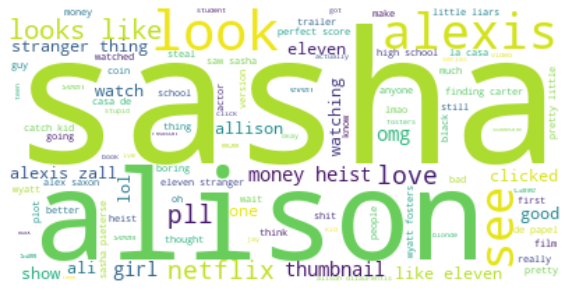

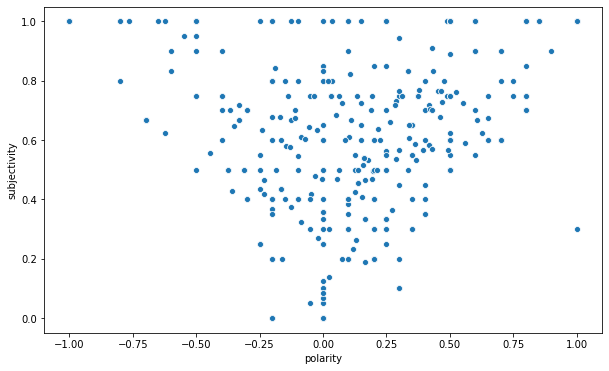

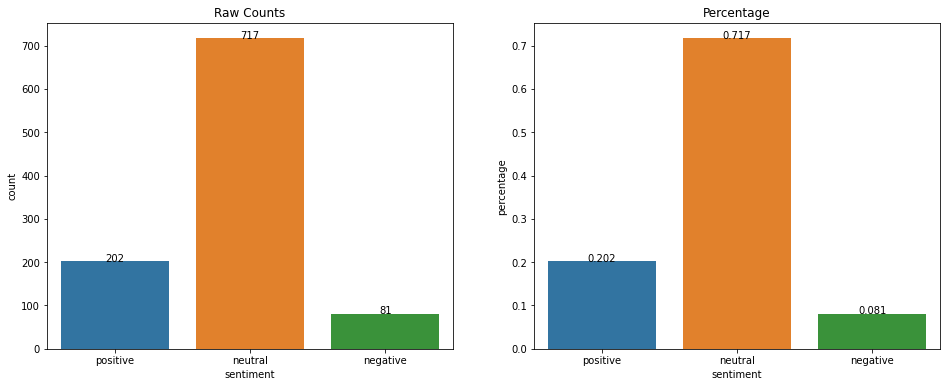

In [360]:
youtube_pipeline(['triple frontier', 'extraction', 'coin heist'])

# TVshow

In [28]:
tvshowDf = pd.read_csv('tvshow_dataset_jul25.csv', usecols=['title','genres','year','originals','everything'])

In [77]:
tvshowDf.originals.value_counts()

0    1268
1     792
Name: originals, dtype: int64

In [29]:
tv_org = tvshowDf.loc[tvshowDf['originals']==1].copy()

tv_genres_count = count_genres(tvshowDf.genres.values.tolist())
tv_org_genres_count = count_genres(tv_org.genres.values.tolist())

tv_genres_count['percentage'] = tv_genres_count['counts'].apply(lambda x: round(x/tv_genres_count.counts.sum(),2))
tv_org_genres_count['percentage'] = tv_org_genres_count['counts'].apply(lambda x: round(x/tv_org_genres_count.counts.sum(),2))

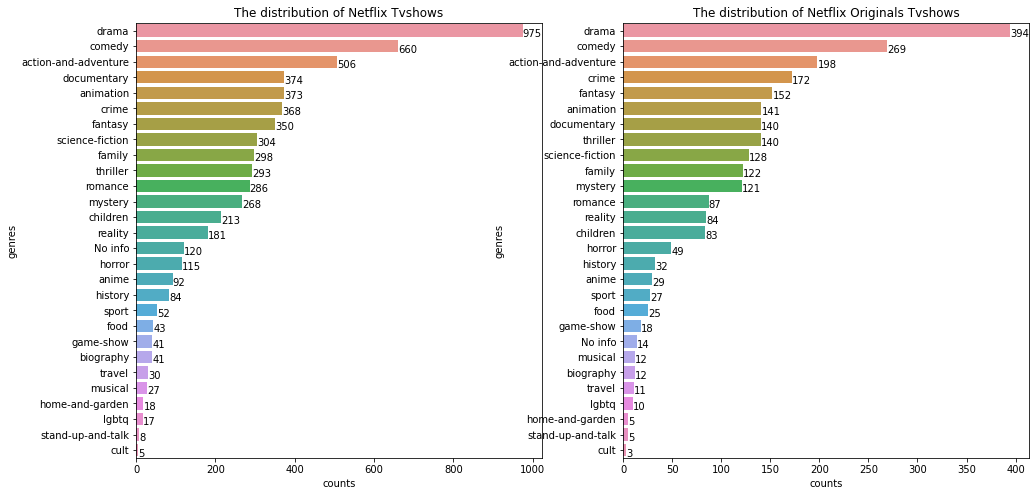

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = tv_genres_count,
                  ax = ax[0],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix Tvshows')

bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = tv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals Tvshows')
plt.show()

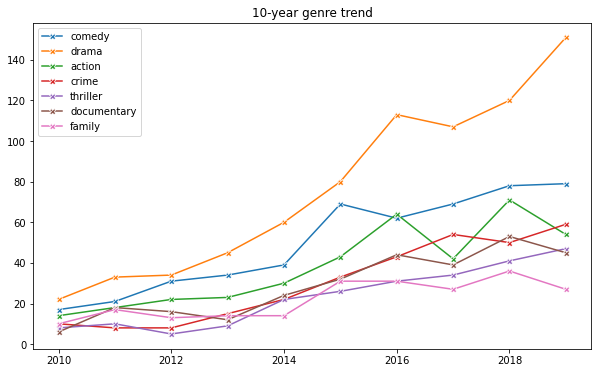

In [36]:
comedy = ten_year_trend(tvshowDf, 'comedy')
drama = ten_year_trend(tvshowDf, 'drama')
action = ten_year_trend(tvshowDf, 'action-and-adventure')
crime = ten_year_trend(tvshowDf, 'crime')
thriller = ten_year_trend(tvshowDf, 'thriller')
documentary = ten_year_trend(tvshowDf, 'documentary')
family = ten_year_trend(tvshowDf, 'family')

fig, ax = plt.subplots(figsize=(10,6))
cd = sns.lineplot(x = list(comedy.keys()), y = list(comedy.values()), marker = 'X', ax = ax, label='comedy')
dm = sns.lineplot(x = list(drama.keys()), y = list(drama.values()), marker = 'X', ax = ax, label='drama')
ac = sns.lineplot(x = list(action.keys()), y = list(action.values()), marker = 'X', ax = ax, label='action')
cm = sns.lineplot(x = list(crime.keys()), y = list(crime.values()), marker = 'X', ax = ax, label='crime')
tl = sns.lineplot(x = list(thriller.keys()), y = list(thriller.values()), marker = 'X', ax = ax, label='thriller')
dc = sns.lineplot(x = list(documentary.keys()), y = list(documentary.values()), marker = 'X', ax = ax, label='documentary')
fm = sns.lineplot(x = list(family.keys()), y = list(family.values()), marker = 'X', ax = ax, label='family')

ax.set_title('10-year genre trend')
plt.show()

In [37]:
tvshowTitleVec = vec_representation(tvshowDf)

In [38]:
len(tvshowTitleVec)

2060

In [39]:
top10_tvshow = [
    'Stranger Things',
    'The Umbrella Academy',
    'Money Heist',
    'You',
    'Sex Education',
    'Our Planet',
    'Unbelievable',
    'Dead to Me',
    'When They See Us',
    'Elite'
]

In [68]:
tvshow_10sim = pd.DataFrame()
for tvshow in top10_tvshow:
    df = get_topN_similar(tvshow, tvshowTitleVec, tvshowDf)
    tvshow_10sim = tvshow_10sim.append(df, ignore_index=True)

In [69]:
orgTvshow_index = tvshow_10sim.loc[tvshow_10sim.originals==1].index.tolist()
for i in [0,11,22,33,44,55,66,77,88,99]:
    orgTvshow_index.remove(i)

In [72]:
orgTvshow = []
for ix in orgTvshow_index:
    orgTvshow.append(tvshow_10sim.iloc[ix,0])

In [80]:
tvshow10sim_titles = tvshow_10sim.title.tolist()
tvshow10sim_year = tvshow_10sim.year.tolist()

In [147]:
# Manuually adjust
tvshow10sim_titles[28] = 'El Cartel de los Sapos'
tvshow10sim_titles[50] = 'cloudy with a chance of meatballs'
tvshow10sim_titles[60] = 'chasing monsters'
tvshow10sim_titles[93] = 'jessica jones'
tvshow10sim_titles[91] = 'vis a vis'
tvshow10sim_titles[104] = 'one of us'
tvshow10sim_titles[108] = 'vis a vis'

tvshow10sim_year[35] = 2019
tvshow10sim_year[57] = 2014
tvshow10sim_year[60] = 2015

In [149]:
tvshow_omdb_results = pd.DataFrame()
for ix in range(110):
    try:
        tvshow_omdb_results = tvshow_omdb_results.append(omdb_get(tvshow10sim_titles[ix],tvshow10sim_year[ix], media_type='series'), ignore_index=True)
    except:
        print(ix)

In [84]:
tvshow_omdb_results.columns

Index(['title', 'year', 'rated', 'released', 'runtime', 'genre', 'director',
       'writer', 'actors', 'plot', 'language', 'country', 'awards', 'poster',
       'ratings', 'metascore', 'imdb_rating', 'imdb_votes', 'imdb_id', 'type',
       'total_seasons', 'response', 'dvd', 'box_office', 'production',
       'website'],
      dtype='object')

## OMDB_RESULT年份分析 TVSHOW

In [152]:
tvshow_omdb_results['year'].tolist()

['2016–',
 '2017–',
 '2019–',
 '2019–',
 '2018',
 '2009–2017',
 '2018–',
 '2011–',
 '2020–',
 '1959–1964',
 '2018',
 '2019–',
 '2016–',
 '2019',
 '2018',
 '2015',
 '2019–',
 '2019–',
 '2003–2006',
 '2019–',
 '2017–',
 '2019–',
 '2017–',
 '2008–',
 '2011–2016',
 '2019–',
 '2018–',
 '2018–',
 '2008–',
 '2015–2017',
 '2014',
 '2016',
 '2004–2007',
 '2018–',
 '2015',
 '2019–',
 '2018–',
 '2016–2020',
 '2016–2017',
 '2014–2016',
 '2019–',
 '2013–',
 '2019–',
 '2017–2019',
 '2019–',
 '2013–2017',
 '2019–',
 '2011–2015',
 '2013–2015',
 '2010–',
 '2017–',
 '2017–2019',
 '2019–',
 '2017',
 '2016–2019',
 '2019',
 '2014–',
 '2014–2019',
 '2012–',
 '2020–',
 '2015–',
 '2011–2012',
 '2012–',
 '2018–',
 '2016–',
 '2013',
 '2019',
 '2012–2016',
 '2019–',
 '2018–',
 '2015–',
 '2016–',
 '2016–',
 '2016–',
 '2017–',
 '2016',
 '2016',
 '2019–',
 '2016',
 '2017–2019',
 '2017–',
 '2019–',
 '2016–2017',
 '2012–2016',
 '2011–2018',
 '2012–',
 '2017–',
 '2009–2011',
 '2019',
 '2018',
 '2020–',
 '2015–2019',
 

In [156]:
# 修改 year 的格式
tvshow_start_year = [tvshow_omdb_results['year'].tolist()[ix].split('–')[0] for ix in range(110)]
tvshow_start_year = [int(y) for y in tvshow_start_year]
tvshow_start_year

[2016,
 2017,
 2019,
 2019,
 2018,
 2009,
 2018,
 2011,
 2020,
 1959,
 2018,
 2019,
 2016,
 2019,
 2018,
 2015,
 2019,
 2019,
 2003,
 2019,
 2017,
 2019,
 2017,
 2008,
 2011,
 2019,
 2018,
 2018,
 2008,
 2015,
 2014,
 2016,
 2004,
 2018,
 2015,
 2019,
 2018,
 2016,
 2016,
 2014,
 2019,
 2013,
 2019,
 2017,
 2019,
 2013,
 2019,
 2011,
 2013,
 2010,
 2017,
 2017,
 2019,
 2017,
 2016,
 2019,
 2014,
 2014,
 2012,
 2020,
 2015,
 2011,
 2012,
 2018,
 2016,
 2013,
 2019,
 2012,
 2019,
 2018,
 2015,
 2016,
 2016,
 2016,
 2017,
 2016,
 2016,
 2019,
 2016,
 2017,
 2017,
 2019,
 2016,
 2012,
 2011,
 2012,
 2017,
 2009,
 2019,
 2018,
 2020,
 2015,
 2015,
 2015,
 2016,
 2014,
 2018,
 2013,
 2012,
 2018,
 2017,
 2020,
 2018,
 2018,
 2016,
 2012,
 2015,
 2018,
 2015,
 2014]

In [157]:
tvshow_omdb_results['year'] = tvshow_start_year

In [158]:
tvshow_year_analysis = sorted(dict(tvshow_omdb_results['year'].value_counts()).items(), key=lambda x: int(x[0]))

In [160]:
tvshow_year_graph = pd.DataFrame(data=tvshow_year_analysis)
# tvshow_year_graph.rename(columns={0:'year',1:'count'}, inplace=True)

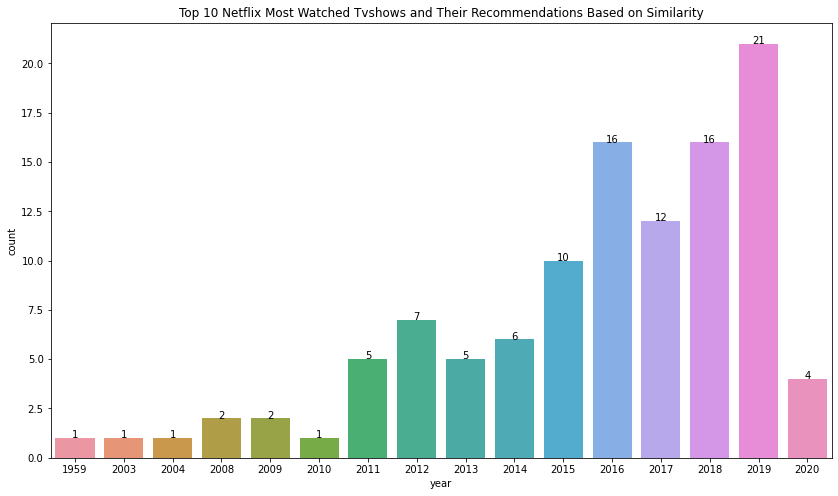

In [161]:
# year_graph.rename(columns={0:'year',1:'count'}, inplace=True)
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x='year', y='count', data=tvshow_year_graph)
show_values_on_bars(ax)
plt.title('Top 10 Netflix Most Watched Tvshows and Their Recommendations Based on Similarity')
plt.show()

In [168]:
org_number = len(orgTvshow)
print(f"There are {org_number} series are produced by Netflix Originals.")

There are 45 series are produced by Netflix Originals.


In [169]:
mapping_for_tvshowCopies = defaultdict(str)
for i in range(10):
    if i != 9:
        mapping_for_tvshowCopies[f"tv0{str(i+1)}"] = top10_tvshow[i]
    else:
        mapping_for_tvshowCopies["tv10"] = top10_tvshow[i]

In [170]:
mapping_for_tvshowCopies

defaultdict(str,
            {'tv01': 'Stranger Things',
             'tv02': 'The Umbrella Academy',
             'tv03': 'Money Heist',
             'tv04': 'You',
             'tv05': 'Sex Education',
             'tv06': 'Our Planet',
             'tv07': 'Unbelievable',
             'tv08': 'Dead to Me',
             'tv09': 'When They See Us',
             'tv10': 'Elite'})

In [171]:
tv01 = tvshow_omdb_results.iloc[0:11,:].copy()
tv02 = tvshow_omdb_results.iloc[11:22,:].copy()
tv03 = tvshow_omdb_results.iloc[22:33,:].copy()
tv04 = tvshow_omdb_results.iloc[33:44,:].copy()
tv05 = tvshow_omdb_results.iloc[44:55,:].copy()
tv06 = tvshow_omdb_results.iloc[55:66,:].copy()
tv07 = tvshow_omdb_results.iloc[66:77,:].copy()
tv08 = tvshow_omdb_results.iloc[77:88,:].copy()
tv09 = tvshow_omdb_results.iloc[88:99,:].copy()
tv10 = tvshow_omdb_results.iloc[99:110,:].copy()

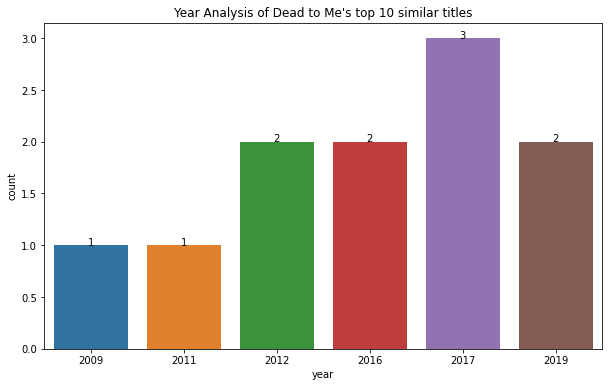

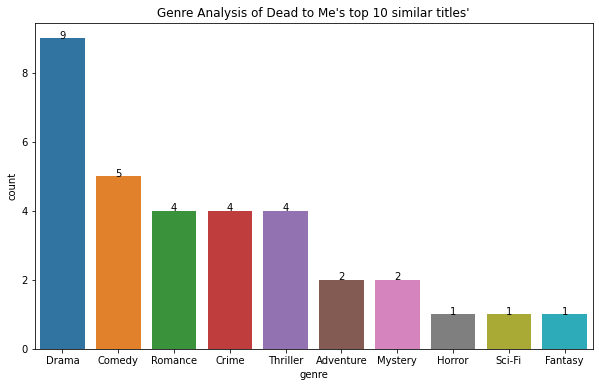

        imdb_rating  imdb_votes
median         7.70       24603
mean           7.67       48593
max            8.60      203768
min            7.00          20
['The End of the F***ing World', 'Lady Dynamite']


In [186]:
pipeline(tv08, media_type='series')

In [180]:
mapping_for_tvshowCopies

defaultdict(str,
            {'tv01': 'Stranger Things',
             'tv02': 'The Umbrella Academy',
             'tv03': 'Money Heist',
             'tv04': 'You',
             'tv05': 'Sex Education',
             'tv06': 'Our Planet',
             'tv07': 'Unbelievable',
             'tv08': 'Dead to Me',
             'tv09': 'When They See Us',
             'tv10': 'Elite'})

In [190]:
tvshow_omdb_results.loc[tvshow_omdb_results.imdb_rating=='N/A']

,title,year,rated,released,runtime,genre,director,writer,actors,plot,...,awards,poster,ratings,metascore,imdb_rating,imdb_votes,imdb_id,type,total_seasons,response
104,ONE of US,2016,N/A,28 Oct 2016,N/A,Comedy,N/A,N/A,"Dean Dodge, Luke Gunn, Constanza Moreno, Marcus Shoemore",N/A,...,N/A,N/A,[],N/A,N/A,N/A,tt6222946,series,N/A,True
